# **Analys The Problem**

Previously on papper "Facial Expression Recognition Methods in the Wild Based on Fusion Feature of Attention Mechanism and LBP (MDPI Sensors 2023 Q2)" authors used a model called ResNet-50 combined CBAM and LBP.

The accuracy took:
- 99.66% on CK+
- 74.23% on FER-2013
- 89.50 on FER-PLUS 
- 88.20 on RAF-DB

**The problem: What if I change the variant of LBP in this method, does it increase the accuracy spesifically for FER-2013 dataset?**

# **About Dataset**

- The paper used 4 dataset include CK+(59 images), FER-2013 (35,887 images), FER-PLUS(31.412 images), RAF-DB (29,672 images)
- CK+ is a controlled dataset and the 3 others datasets are uncontrolled datasets
- Controlled dataset has good lightning and pose but uncontrolled datasets got a random of it

# **Method**

## Paper's Method

- **ResNet-18 + CBAM**

    1. Architecture of ResNet-18:
    
        <img src="../src/Structure-of-a-ResNet-18-architecture.png" alt="Windowing of Feature in Faces" width="350" height="250">

    2. CBAM Architecture:

        <img src="../src/cbam.png" alt="Windowing of Feature in Faces" width="600" height="100">

    3. Authors combine the CBAM module into each block of the ResNet-18 architecture,
    
        Before and After implement the CBAM module:

        <img src="../src/oriblock.png" alt="Windowing of Feature in Faces" width="150" height="200">
        <img src="../src/blocknCbam.png" alt="Windowing of Feature in Faces" width="150" height="200">

- **Local Binary Patterns (LBP)**

    LBP is one of the most generally used texture pattern descriptors for examining local grain features and is regarded as one of the best methods for texture processing, which is widely employed in image processing.

- **RCL-Net Model**

    After combining all the method such as LBP and ResNet-CBAM, this architecture called by **RCL-Net Model**,

    <img src="../src/rcl-net.png" alt="Windowing of Feature in Faces" width="700" height="200">



## Proposed Method

- In planning, switching LBP method in previous architecture with the newest or other variant LBP

# **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# for augmen:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as T

# for mixup augmen:
import torch
import random

# mixup from train.py file
import argparse
import os
import sys

# LBP
import cv2
import torch.nn as nn
import math

from torch.utils.data import Dataset, DataLoader

d:\Ando File 4 Kuliah\A SKRIPSI\RISETku\KERJA\CODE\venv\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print(torch.cuda.is_available())

True


In [3]:
torch.cuda.empty_cache()  # Bersihkan cache CUDA

# **DATA LOADING**

- Making dataframe:

In [4]:
# Baca file CSV
# file_path_train = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv'  # Ganti dengan lokasi file kamu
# df_train = pd.read_csv(file_path_train)

# file_path_test = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv'  # Ganti dengan lokasi file kamu
# df_test = pd.read_csv(file_path_test)

file_path = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'  # Ganti dengan lokasi file kamu
df = pd.read_csv(file_path)

- Visualize the data on datatables:

In [5]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# **PREPROCESSING**

## Resized Image 100 x 100:

- Define function resized:

In [6]:
# Fungsi untuk mengubah string pixel menjadi gambar
def convert_to_image(pixels, size=(48, 48), new_size=(100, 100)):
    # Ubah string pixel menjadi array
    pixel_values = np.array(pixels.split(), dtype=np.uint8)
    
    # Ubah array 1D menjadi array 2D
    image = pixel_values.reshape(size)
    
    # Buat gambar dari array 2D
    img = Image.fromarray(image)
    
    # Ubah ukuran gambar menggunakan LANCZOS untuk kualitas terbaik
    resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    return resized_img

- Processing the resize to all images and saved to new dataframe:

In [7]:
df_resized = pd.DataFrame(columns=['emotion', 'usage', 'resized_pixels']) # DataFrame baru untuk menyimpan gambar yang sudah diproses

# Proses setiap baris di DataFrame asli dengan progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images"):
    pixels = row[' pixels']
    
    # Konversi pixel menjadi gambar dan resize
    resized_image = convert_to_image(pixels)
    
    # Ubah gambar yang diresize menjadi array 1D untuk disimpan dalam DataFrame
    resized_image_array = np.array(resized_image).flatten()
    
    # Buat DataFrame baru untuk baris ini
    new_row = pd.DataFrame({
        'emotion': [row['emotion']],
        'usage': [row[' Usage']],
        'resized_pixels': [' '.join(resized_image_array.astype(str))]
    })
    
    # Gabungkan baris baru dengan DataFrame yang sudah ada
    df_resized = pd.concat([df_resized, new_row], ignore_index=True)

Processing Images: 100%|██████████| 35887/35887 [03:57<00:00, 151.05it/s]


- Checking info of dataset:

In [8]:
df_resized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         35887 non-null  object
 1   usage           35887 non-null  object
 2   resized_pixels  35887 non-null  object
dtypes: object(3)
memory usage: 841.2+ KB


In [9]:
df_resized.describe()

,emotion,usage,resized_pixels
count,35887,35887,35887
unique,7,3,34034
top,3,Training,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
freq,8989,28709,12


In [10]:
df_resized.head()

,emotion,usage,resized_pixels
0,0,Training,69 71 77 84 86 84 80 72 64 59 57 57 57 58 61 6...
1,0,Training,151 151 151 149 147 148 152 155 153 148 144 13...
2,2,Training,230 232 227 205 173 154 153 166 178 175 154 13...
3,4,Training,23 25 28 34 37 36 32 29 31 32 28 23 20 19 18 2...
4,6,Training,6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


Checking column's names:

In [11]:
df_resized.columns

Index(['emotion', 'usage', 'resized_pixels'], dtype='object')

Checking unique value in "Usage" columnns:

In [12]:
df_resized['usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

Separating between trai, public, and private test:

In [13]:
# Filter data yang Usage-nya "Training"
df_train = df_resized[df_resized['usage'] == 'Training']
df_public_test = df_resized[df_resized['usage'] == 'PublicTest']
df_private_test = df_resized[df_resized['usage'] == 'PrivateTest']

- Checking total of row and column:

In [14]:
print(df_train.shape)
print(df_public_test.shape)
print(df_private_test.shape)

(28709, 3)
(3589, 3)
(3589, 3)


- Before Resized 48x48:

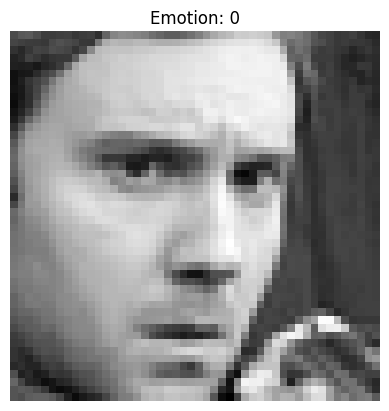

In [15]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # Ganti dengan indeks baris yang diinginkan
pixels = df[' pixels'][row_index]

# Ubah string pixel menjadi array 1D
pixel_values = np.array(pixels.split(), dtype=np.uint8)

# Ubah array 1D menjadi array 2D
image = pixel_values.reshape(48, 48)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {df['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

- After resized 100x100:

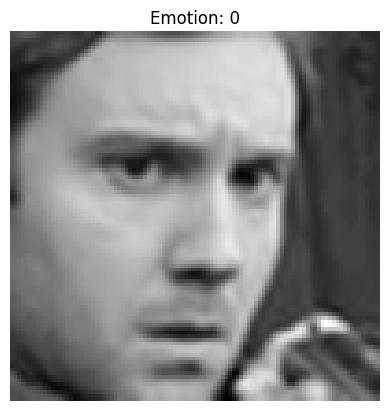

In [16]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # indeks baris yang diinginkan
pixels = df_resized['resized_pixels'][row_index]

# Ubah string pixel menjadi array 1D
pixel_values = np.array(pixels.split(), dtype=np.uint8)

# Ubah array 1D menjadi array 2D (100x100)
image = pixel_values.reshape(100, 100)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {df_resized['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

Menerapkan minimum data:

In [17]:
# Menghitung total data per label pada kolom 'emotion'
label_counts = df_train.groupby('emotion').size()

# Menampilkan hasil
print(label_counts)

emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
dtype: int64


In [18]:
# Tentukan jumlah data yang diinginkan per label
desired_count = 436

# List untuk menyimpan DataFrame setiap label setelah disampling
balanced_dataframes = []

# Loop untuk setiap label di kolom 'emotion'
for label, group in df_train.groupby('emotion'):
    if len(group) > desired_count:
        # Jika jumlah data lebih dari desired_count, lakukan undersampling
        sampled_group = group.sample(n=desired_count, random_state=42)
    else:
        # Jika jumlah data kurang atau sama dengan desired_count, gunakan semua data
        sampled_group = group
    
    # Tambahkan data yang telah disampling ke dalam list
    balanced_dataframes.append(sampled_group)

# Gabungkan semua data yang telah diundersampling menjadi satu DataFrame
balanced_df_train = pd.concat(balanced_dataframes)

# Menampilkan total data per label setelah undersampling
print(balanced_df_train.groupby('emotion').size())

emotion
0    436
1    436
2    436
3    436
4    436
5    436
6    436
dtype: int64


In [19]:
# Reset indeks setelah melakukan sampling atau filtering
balanced_df_train = balanced_df_train.reset_index(drop=True)

In [20]:
balanced_df_train.head()

,emotion,usage,resized_pixels
0,0,Training,136 129 115 100 89 79 67 53 37 26 25 29 33 35 ...
1,0,Training,25 23 18 17 22 29 34 34 31 26 25 24 22 24 32 4...
2,0,Training,229 226 222 216 214 212 212 211 213 215 218 22...
3,0,Training,220 223 225 229 224 189 127 83 76 88 92 90 89 ...
4,0,Training,71 79 93 108 108 92 64 42 41 52 63 71 76 78 83...


In [21]:
balanced_df_train.shape

(3052, 3)

## Augmantation

- Define augmentation function:

In [22]:
# Fungsi augmentasi
def augment_image(image):
    # Pipeline augmentasi menggunakan albumentations
    transform = A.Compose([
        A.RandomCrop(width=90, height=90),         # Random crop ukuran 80x80 dari gambar asli (100x100)
        A.HorizontalFlip(p=0.5),                   # Membalik gambar secara horizontal dengan probabilitas 50%
        A.Rotate(limit=20, p=0.5),                 # Memutar gambar dengan sudut hingga 20 derajat
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Jitter warna
        A.CoarseDropout(max_holes=4, max_height=5, max_width=5, p=0.5),  # Random masking
        A.Resize(100, 100),                        # Resize kembali menjadi ukuran 100x100
        # A.Normalize(mean=(0.5,), std=(0.5,)),      # Dibuatr normalize 0,1 agar bentuknya kembali semula kalo ini dihilangkan outputnya pecah, gak jadi ini setelah augmentasi
        ToTensorV2()                               # Ubah gambar menjadi tensor PyTorch
    ])
    
    augmented = transform(image=image)
    return augmented['image']

- Processing the augmentation:

In [23]:
# List untuk menyimpan hasil augmentasi
augmented_images = []
augmented_emotions = []

# Proses augmentasi untuk setiap gambar di dataframe asli
for i in tqdm(range(len(balanced_df_train)), desc="Augmenting images"):
    # Ambil gambar dari dataframe dan ubah menjadi array 2D
    pixels = np.array(balanced_df_train['resized_pixels'][i].split(), dtype=np.uint8).reshape(100, 100)
    
    # Augmentasi gambar
    augmented_image = augment_image(pixels)
    
    # Ubah tensor augmented_image kembali ke numpy array, lalu ubah jadi string lagi untuk disimpan di dataframe
    augmented_image_np = augmented_image.permute(1, 2, 0).numpy().flatten().tolist()  # Ubah ke list 1D
    augmented_image_str = ' '.join(map(str, augmented_image_np))  # Ubah list jadi string
    
    # Simpan gambar yang sudah di-augmentasi dan emosi ke list
    augmented_images.append(augmented_image_str)
    augmented_emotions.append(balanced_df_train['emotion'][i])

# Masukkan hasil augmentasi ke dataframe baru
augmented_df_train = pd.DataFrame({
    'emotion': augmented_emotions,
    'resized_pixels': augmented_images
})

Augmenting images: 100%|██████████| 3052/3052 [00:16<00:00, 185.75it/s]


In [27]:
augmented_df_train

,emotion,resized_pixels
0,0,37 39 38 37 37 37 33 25 17 15 17 18 18 18 17 1...
1,0,32 32 31 29 29 33 41 46 46 48 56 64 70 73 74 7...
2,0,10 6 1 0 0 0 6 20 28 28 31 45 67 93 117 132 13...
3,0,168 169 169 168 168 168 169 171 172 173 172 17...
4,0,114 111 103 92 79 68 59 51 46 43 38 33 31 37 5...
...,...,...
3047,6,133 136 139 141 141 138 136 140 152 166 169 16...
3048,6,20 21 21 22 23 26 29 33 38 42 49 58 67 76 82 8...
3049,6,69 73 80 92 108 125 143 157 168 178 187 196 20...
3050,6,165 178 185 189 190 192 194 197 199 202 202 20...


- Visualize image after augmentation:

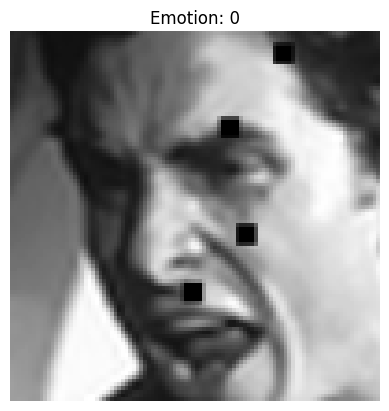

In [28]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # Ganti dengan indeks baris yang diinginkan
pixels = augmented_df_train['resized_pixels'][row_index]

# Ubah string pixel menjadi array 1D (float)
pixel_values = np.array(pixels.split(), dtype=np.float32)

# Denormalisasi dari rentang [-1, 1] ke [0, 255]
# pixel_values = (pixel_values * 0.5 + 0.5) * 255  # Skala ulang ke [0, 255]

# Ubah array 1D menjadi array 2D (100x100)
image = pixel_values.reshape(100, 100)

# Ubah ke tipe data uint8 agar bisa ditampilkan sebagai gambar
image = image.astype(np.uint8)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {augmented_df_train['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()


- Append the new augmentation into original dataframe before the augmentation:

In [32]:
# Gabungkan dataframe asli dengan dataframe augmented
combined_df_train = pd.concat([balanced_df_train, augmented_df_train], ignore_index=True)

# Tampilkan informasi jumlah data
print(f"Jumlah data setelah augmentasi: {len(combined_df_train)}")

# Tampilkan contoh baris dari dataframe gabungan
print(combined_df_train.head())

Jumlah data setelah augmentasi: 6104
  emotion     usage                                     resized_pixels
0       0  Training  136 129 115 100 89 79 67 53 37 26 25 29 33 35 ...
1       0  Training  25 23 18 17 22 29 34 34 31 26 25 24 22 24 32 4...
2       0  Training  229 226 222 216 214 212 212 211 213 215 218 22...
3       0  Training  220 223 225 229 224 189 127 83 76 88 92 90 89 ...
4       0  Training  71 79 93 108 108 92 64 42 41 52 63 71 76 78 83...


- Define function normalize pixel to [0,1] dividing by 255:

In [33]:
# Fungsi untuk normalisasi nilai piksel
def normalize_pixels(pixels):
    # Ubah string pixel menjadi array float
    pixel_values = np.array(pixels.split(), dtype=np.float32)
    
    # Bagi setiap nilai piksel dengan 255 untuk menormalisasi ke [0,1]
    normalized_pixel_values = pixel_values / 255.0
    
    # Ubah kembali array menjadi string agar sesuai dengan format dataframe
    return ' '.join(map(str, normalized_pixel_values))

- Proceeding the normalize to all row:

In [34]:
# Terapkan normalisasi dengan progress bar
tqdm.pandas()  # Untuk menambahkan kemampuan progress bar pada pandas

# Normalisasi pada kolom 'resized_pixels' dengan progress bar
combined_df_train['resized_pixels'] = combined_df_train['resized_pixels'].progress_apply(normalize_pixels)

100%|██████████| 6104/6104 [00:34<00:00, 175.71it/s]


In [37]:
# Terapkan normalisasi dengan progress bar
tqdm.pandas()  # Untuk menambahkan kemampuan progress bar pada pandas

# Normalisasi pada kolom 'resized_pixels' dengan progress bar
# Menggunakan .loc[] untuk mengubah kolom secara aman
df_public_test.loc[:, 'resized_pixels'] = df_public_test['resized_pixels'].progress_apply(normalize_pixels)

100%|██████████| 3589/3589 [00:21<00:00, 168.68it/s]


- Visualize datatable:

In [39]:
# Tampilan hasil original + augmentasi dataframe setelah normalisasi
combined_df_train.head()

,emotion,usage,resized_pixels
0,0,Training,0.53333336 0.5058824 0.4509804 0.39215687 0.34...
1,0,Training,0.09803922 0.09019608 0.07058824 0.06666667 0....
2,0,Training,0.8980392 0.8862745 0.87058824 0.84705883 0.83...
3,0,Training,0.8627451 0.8745098 0.88235295 0.8980392 0.878...
4,0,Training,0.2784314 0.30980393 0.3647059 0.42352942 0.42...


In [40]:
# Tampilan hasil df_public_test dataframe setelah normalisasi
df_public_test.head()

,emotion,usage,resized_pixels
28709,0,PublicTest,0.99607843 0.99607843 0.99607843 0.99607843 0....
28710,1,PublicTest,0.6039216 0.6313726 0.68235296 0.7411765 0.768...
28711,4,PublicTest,0.23529412 0.3137255 0.43137255 0.45490196 0.3...
28712,6,PublicTest,0.83137256 0.8 0.75686276 0.80784315 0.9215686...
28713,3,PublicTest,0.3372549 0.33333334 0.32156864 0.30980393 0.3...


Kolom emotion: Jika ini adalah label kelas, awalnya tipe object maka bisa mengubahnya menjadi tipe data numerik menggunakan LabelEncoder dari scikit-learn:

In [41]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
combined_df_train['emotion'] = le.fit_transform(combined_df_train['emotion'])

Kolom resized_pixels: Jika kolom ini berisi string yang merepresentasikan array alias saat ini tipe object, maka perlu mengubahnya menjadi array numpy:

In [42]:
# Konversi string piksel menjadi array NumPy data train
combined_df_train['resized_pixels'] = combined_df_train['resized_pixels'].apply(
    lambda x: np.fromstring(x, sep=' ').astype(np.float32).reshape(100, 100)
)

In [43]:
combined_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6104 entries, 0 to 6103
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         6104 non-null   int64 
 1   usage           3052 non-null   object
 2   resized_pixels  6104 non-null   object
dtypes: int64(1), object(2)
memory usage: 143.2+ KB


In [44]:
# Konversi string piksel menjadi array NumPy data test
df_public_test.loc[:, 'resized_pixels'] = df_public_test['resized_pixels'].apply(
    lambda x: np.fromstring(x, sep=' ').astype(np.float32).reshape(100, 100)
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18020\41601893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_public_test['resized_pixels'] = df_public_test['resized_pixels'].apply(


In [45]:
# Pastikan semua entri memiliki ukuran 100x100
print(combined_df_train['resized_pixels'].apply(lambda x: x.shape == (100, 100)).all())
print(df_public_test['resized_pixels'].apply(lambda x: x.shape == (100, 100)).all())

True
True


In [49]:
# Tampilkan informasi dataframe setelah normalisasi
combined_df_train.head()

,emotion,usage,resized_pixels
0,0,Training,"[[0.53333336, 0.5058824, 0.4509804, 0.39215687..."
1,0,Training,"[[0.09803922, 0.09019608, 0.07058824, 0.066666..."
2,0,Training,"[[0.8980392, 0.8862745, 0.87058824, 0.84705883..."
3,0,Training,"[[0.8627451, 0.8745098, 0.88235295, 0.8980392,..."
4,0,Training,"[[0.2784314, 0.30980393, 0.3647059, 0.42352942..."


In [48]:
# Tampilkan informasi dataframe setelah normalisasi
df_public_test.head()

,emotion,usage,resized_pixels
28709,0,PublicTest,"[[0.99607843, 0.99607843, 0.99607843, 0.996078..."
28710,1,PublicTest,"[[0.6039216, 0.6313726, 0.68235296, 0.7411765,..."
28711,4,PublicTest,"[[0.23529412, 0.3137255, 0.43137255, 0.4549019..."
28712,6,PublicTest,"[[0.83137256, 0.8, 0.75686276, 0.80784315, 0.9..."
28713,3,PublicTest,"[[0.3372549, 0.33333334, 0.32156864, 0.3098039..."


## Mixup Augmentation

- Define function Mixup image and labels:

In [19]:
def mixup_images_labels(images, labels, alpha=0.2):
    """Menerapkan Mixup Augmentation pada dua gambar dan label.
    
    Args:
        images (tensor): Tensor gambar-gambar dengan shape (batch_size, channels, height, width).
        labels (tensor): Tensor one-hot encoded label dengan shape (batch_size, num_classes).
        alpha (float): Parameter distribusi Beta untuk campuran.

    Returns:
        mixed_images: Gambar campuran.
        mixed_labels: Label campuran.
    """
    # Ambil nilai lambda dari distribusi Beta
    lambda_val = np.random.beta(alpha, alpha)
    
    # Pilih dua indeks acak
    index = torch.randperm(images.size(0))
    
    # Gabungkan dua gambar
    mixed_images = lambda_val * images + (1 - lambda_val) * images[index, :]
    
    # Gabungkan label
    mixed_labels = lambda_val * labels + (1 - lambda_val) * labels[index, :]
    
    return mixed_images, mixed_labels


- Define function for data preparation before mixup: 

In [20]:
# Pastikan gambar dalam format tensor dan normalisasi ke [0, 1]
def prepare_images_labels(df):
    images = []
    labels = []

    for i in tqdm(range(len(df))):
        # Ambil pixel dan konversi ke array numpy
        pixels = np.array(df['resized_pixels'][i].split(), dtype=np.float32).reshape(100, 100) / 255.0
        
        # Tambahkan channel dimension untuk tensor (1 channel karena grayscale)
        images.append(pixels[np.newaxis, :, :])
        
        # Ambil label (ekspresi) dan ubah menjadi one-hot encoding
        label = df['emotion'][i]
        one_hot_label = np.zeros(8)  # Misal 8 kelas ekspresi
        one_hot_label[label] = 1
        labels.append(one_hot_label)

    # Ubah list ke tensor
    images = torch.tensor(np.array(images), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)
    
    return images, labels

In [ ]:
# Persiapkan gambar dan label dari combined_df
images, labels = prepare_images_labels(combined_df)

- Processing Mixup Augmentation:

In [ ]:
# Batch size untuk Mixup Augmentation
batch_size = 64  # Batch size 64

# Acak gambar dan label untuk setiap batch
for i in tqdm(range(0, len(images), batch_size)):
    batch_images = images[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    
    # Terapkan Mixup Augmentation
    mixed_images, mixed_labels = mixup_images_labels(batch_images, batch_labels, alpha=0.2)

# (Selanjutnya, mixed_images dan mixed_labels dapat digunakan untuk training model)

In [ ]:
mixed_images

In [ ]:
mixed_labels

- Visualize the result of mixup augmented:

In [ ]:
mixed_image = mixed_images[0, 0]  # Ambil gambar pertama dari saluran pertama

# Ubah tensor ke numpy array
image = mixed_image.detach().numpy()  # Mengubah tensor menjadi numpy array

# Denormalisasi jika perlu, misal dari rentang [-1, 1] ke [0, 255]
image = (image * 0.5 + 0.5) * 255  # Skala ulang ke [0, 255]

# Pastikan untuk mengubah tipe data menjadi uint8
image = (image * 255).astype(np.uint8)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hilangkan sumbu
plt.title("Mixed Image")
plt.show()


# MODELING

Konversi DataFrame ke Tensor:

In [50]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = torch.tensor(self.dataframe['resized_pixels'].iloc[idx], dtype=torch.float32).view(1, 100, 100)  # Jika gambar 100x100
        label = torch.tensor(self.dataframe['emotion'].iloc[idx], dtype=torch.long)
        return image, label


Membuat DataLoader:

In [51]:
# Inisialisasi dataset
train_dataset = EmotionDataset(combined_df_train)
test_dataset = EmotionDataset(df_public_test)

# Inisialisasi DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

LBP circular

In [53]:
# Fungsi untuk mendapatkan intensitas piksel tetangga menggunakan interpolasi bilinear
def get_pixel_value(img, center, x, y):
    # Jika tetangga berada di dalam batas gambar
    if x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[1]:
        return img[int(x)][int(y)]
    else:
        return center

# Fungsi untuk menghitung Circular LBP pada piksel (x, y)
def lbp_calculated_pixel(img, x, y, radius, neighbors):
    center = img[x][y]
    values = []
    
    # Looping untuk mengambil nilai tetangga dalam pola melingkar
    for n in range(neighbors):
        theta = 2 * math.pi * n / neighbors  # Sudut
        x_n = x + radius * math.sin(theta)   # Koordinat tetangga dalam pola melingkar
        y_n = y + radius * math.cos(theta)
        neighbor_value = get_pixel_value(img, center, x_n, y_n)
        values.append(1 if neighbor_value >= center else 0)
    
    # Menghitung nilai biner LBP
    lbp_value = 0
    for i in range(len(values)):
        lbp_value += values[i] * (1 << i)  # 1 << i adalah 2^i
    
    return lbp_value

# Fungsi untuk menghitung Circular LBP untuk seluruh citra
def calculate_lbp_image(img, radius=1, neighbors=8):
    height, width = img.shape
    lbp_image = np.zeros((height, width), dtype=np.uint32)  # Mengubah tipe data ke uint32 untuk mendukung nilai besar
    
    for i in range(radius, height - radius):
        for j in range(radius, width - radius):
            lbp_image[i, j] = lbp_calculated_pixel(img, i, j, radius, neighbors)
    
    # Normalisasi jika diperlukan (mengembalikan nilai dalam rentang 0-255)
    lbp_image_normalized = np.uint8(lbp_image / lbp_image.max() * 255)
    
    return lbp_image_normalized

# Fungsi untuk menampilkan hasil
# def show_output(original_img, lbp_img):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
#     # Gambar asli (grayscale)
#     axs[0].imshow(original_img, cmap='gray')
#     axs[0].set_title('Original Grayscale Image')
    
#     # Hasil LBP
#     axs[1].imshow(lbp_img, cmap='gray')
#     axs[1].set_title('Circular LBP Image')
    
#     plt.show()

# Fungsi untuk ekstraksi fitur LBP dari batch gambar
def lbp_feature_extraction_batch(images, radius=3, neighbors=24):
    lbp_features = []
    for img in images:
        lbp_img = calculate_lbp_image(img.squeeze().cpu().numpy(), radius, neighbors)  # Ekstraksi LBP dari gambar
        lbp_hist, _ = np.histogram(lbp_img.ravel(), bins=np.arange(0, neighbors + 3), range=(0, neighbors + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= lbp_hist.sum()  # Normalisasi histogram
        lbp_features.append(lbp_hist)

    return np.array(lbp_features)
    
neighbors=24 # samakan dengan tabel dari referensi circular lbp ini yang optimal

# Definisikan ukuran fitur LBP
lbp_feature_size = neighbors + 2  # Misalnya 26 untuk 24 neighbors  

# Main function
# def lbp_feature_extraction(image):
#     # Membaca citra
#     # image_file = '../src/lenna.jpg'
#     image_file = image
#     img_bgr = cv2.imread(image_file)
#     img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
#     # Hitung LBP dengan radius 3 dan 24 tetangga
#     lbp_img = calculate_lbp_image(img_gray, radius=3, neighbors=24)
    
#     # Tampilkan hasilnya
#     show_output(img_gray, lbp_img)

#     return lbp_img

# if __name__ == "__main__":
#     lbp_img = lbp_feature_extraction()


Mengonversi Output LBP menjadi Vektor dan Menghubungkan ke FC Layer:

In [54]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # MLP
        self.fc1 = nn.Conv2d(in_channels, in_channels // ratio, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // ratio, in_channels, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# CBAM Module (Channel + Spatial Attention)
class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x


In [55]:
class ResNet18_CBAM(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18_CBAM, self).__init__()
        
        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()
        
        # BLOCK-1 (starting block) input=(224x224) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        # CBAM after block1
        self.cbam1 = CBAM(64)

        # BLOCK-2 (1) input=(56x56) output = (56x56)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block2
        self.cbam2 = CBAM(64)
        
        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block3
        self.cbam3 = CBAM(128)

        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block4
        self.cbam4 = CBAM(256)

        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block5
        self.cbam5 = CBAM(512)
        
        # Final Block input=(7x7) 
        # self.avgpool = nn.AvgPool2d(kernel_size=(7, 7), stride=(7, 7))  # Mengubah output menjadi (512, 1, 1)
        self.avgpool = nn.AvgPool2d(kernel_size=(4, 4), stride=(4, 4))  # Output akan menjadi (512, 1, 1)
        self.fc = nn.Linear(in_features=1 * 1 * 512, out_features=1000)  # 512 dari avgpool
        self.out = nn.Linear(in_features=1000, out_features=n_classes)  # n_classes sesuai dengan jumlah kelas
        # END

    def forward(self, x):
        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)
        op1 = self.cbam1(op1)
        # print(f"Output after Block 1: {op1.shape}")  # Cek ukuran output
        
        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1 
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2 
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)
        op2 = self.cbam2(op2)
        # print(f"Output after Block 2: {op2.shape}")  # Cek ukuran output
        
        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2 
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)
        op3 = self.cbam3(op3)
        # print(f"Output after Block 3: {op3.shape}")  # Cek ukuran output

        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)
        op4 = self.cbam4(op4)
        # print(f"Output after Block 4: {op4.shape}")  # Cek ukuran output

        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_2(self.conv5_2_2(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)
        op5 = self.cbam5(op5)
        # print(f"Output after Block 5: {op5.shape}")  # Cek ukuran output
        
        # final operations
        x = self.avgpool(op5)
        # print(f"Shape after avgpool: {x.shape}")
        x = torch.flatten(x, 1)
        # print(f"Shape after flatten: {x.shape}")
        xfeatures = self.fc(x)
        # print(f"Output after fc: {x.shape}")  # Cek ukuran output
        # x = self.out(x) # Jangan panggil self.out
        # print(f"Output self.out: {x.shape}")  # Cek ukuran output
        return xfeatures


In [56]:
class CombinedModel(nn.Module):
    def __init__(self, n_classes, lbp_feature_size):
        super(CombinedModel, self).__init__()
        self.resnet = ResNet18_CBAM(n_classes)
        self.fc_lbp = nn.Linear(lbp_feature_size, 128)  # Ubah lbp_feature_size sesuai ukuran LBP
        self.fc_combined = nn.Linear(128 + 1000, n_classes)  # Gabungkan output LBP dan ResNet

    def forward(self, x):
        # Ekstraksi fitur LBP
        lbp_features = lbp_feature_extraction_batch(x)  # Ekstrak fitur LBP
        lbp_features = torch.from_numpy(lbp_features).float().to(x.device)  # Konversi ke tensor dan pindahkan ke device
        lbp_features = lbp_features.view(lbp_features.size(0), -1)  # Flatten jika perlu
        # print(f"LBP feature size: {lbp_features.shape}")
        
        # Proses fitur LBP
        lbp_features = self.fc_lbp(lbp_features)
        # print(f"Processed LBP feature size: {lbp_features.shape}")
        
        # Proses melalui ResNet (output fitur sebelum klasifikasi akhir)
        resnet_output = self.resnet(x)  # Output [32,1000]
        # print(f"ResNet output size: {resnet_output.shape}")
        
        # Gabungkan output LBP dan ResNet
        combined = torch.cat((lbp_features, resnet_output), dim=1)  # [32,1128]
        # print(f"Combined feature size: {combined.shape}")
        
        # Proses melalui fully connected layer
        output = self.fc_combined(combined)  # [32,7]
        # print(f"Output after fc_combined: {output.shape}")
        
        return output

Training Model dengan Batch Processing:


In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Memastikan tidak ada diluar rentang 0-6 pada label:


In [58]:
labels = torch.tensor(combined_df_train['emotion'].values)
print(labels.unique())  # Pastikan label tidak ada yang out-of-range

tensor([0, 1, 2, 3, 4, 5, 6])


In [112]:
# device = torch.device('cpu')
# model = CombinedModel(n_classes=7, lbp_feature_size=lbp_feature_size).to(device)

In [59]:
device

device(type='cuda')

In [63]:
import torch

# Inisialisasi model dan optimasi
model = CombinedModel(n_classes=7, lbp_feature_size=lbp_feature_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.1, weight_decay=0.0001)

# Variabel untuk menyimpan akurasi terbaik
best_accuracy = 0.0
start_epoch = 0  # Epoch awal default

# Jika ingin melanjutkan dari checkpoint
checkpoint_path = 'model_checkpoint_latest.pt'  # Nama file checkpoint terakhir
try:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_accuracy = checkpoint['accuracy']
    start_epoch = checkpoint['epoch']  # Mulai dari epoch terakhir
    print(f"Melanjutkan dari epoch {start_epoch+1}, Akurasi terbaik: {best_accuracy:.2f}%")
except FileNotFoundError:
    print("Tidak ada checkpoint, memulai training dari awal.")

# Training loop dengan validasi
epochs = 10
for epoch in range(start_epoch, epochs):
    running_loss = 0.0
    model.train()
    
    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
    
    for images, labels in progress_bar_train:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar_train.set_postfix({'Training Loss': loss.item()})
    
    average_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Training Loss: {average_loss:.4f}")

    # Validasi
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    progress_bar_val = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Validating]")

    with torch.no_grad():
        for images, labels in progress_bar_val:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar_val.set_postfix({'Validation Loss': loss.item()})

        val_loss /= len(test_loader)
        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Simpan model jika akurasi lebih baik dari sebelumnya (model dengan akurasi terbaik)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        checkpoint_best = {
            'epoch': epoch + 1,  # Simpan epoch berikutnya
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'accuracy': accuracy,
        }
        torch.save(checkpoint_best, 'model_checkpoint_best.pt')
        print(f"Model dengan akurasi terbaik disimpan: {accuracy:.2f}% pada epoch {epoch + 1}")

    # Simpan model terakhir yang di-train (model terakhir setiap epoch)
    checkpoint_latest = {
        'epoch': epoch + 1,  # Simpan epoch berikutnya
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss,
        'accuracy': accuracy,
    }
    torch.save(checkpoint_latest, 'model_checkpoint_latest.pt')
    print(f"Model terakhir disimpan setelah epoch {epoch + 1}")

print("Training dan validasi selesai.")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18020\3873053852.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Melanjutkan dari epoch 2, Akurasi terbaik: 16.91%


Epoch 2/10 [Training]:   0%|          | 0/96 [00:06<?, ?it/s]


KeyboardInterrupt: 